<a href="https://colab.research.google.com/github/OrangeSunProgramming/brain-tumor-classification/blob/main/augmented_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importing all the libraries necessary for the DNN project
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Getting the training and validation dataset
image_height = 180
image_width = 180
batch_size = 32

dataset_dir = "/content/drive/MyDrive/brain_tumor_classification_dataset/brain_tumor_dataset/brain_tumor_classification/Training"
train_ds = tf.keras.utils.image_dataset_from_directory(dataset_dir, validation_split=0.2, subset="training", seed=72, image_size=(image_height, image_width), batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(dataset_dir, validation_split=0.2, subset="validation", seed=72, image_size=(image_height, image_width), batch_size=batch_size)

Found 2870 files belonging to 4 classes.
Using 2296 files for training.
Found 2870 files belonging to 4 classes.
Using 574 files for validation.


In [3]:
class_names = train_ds.class_names
print(f"The classes: {class_names}")

The classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


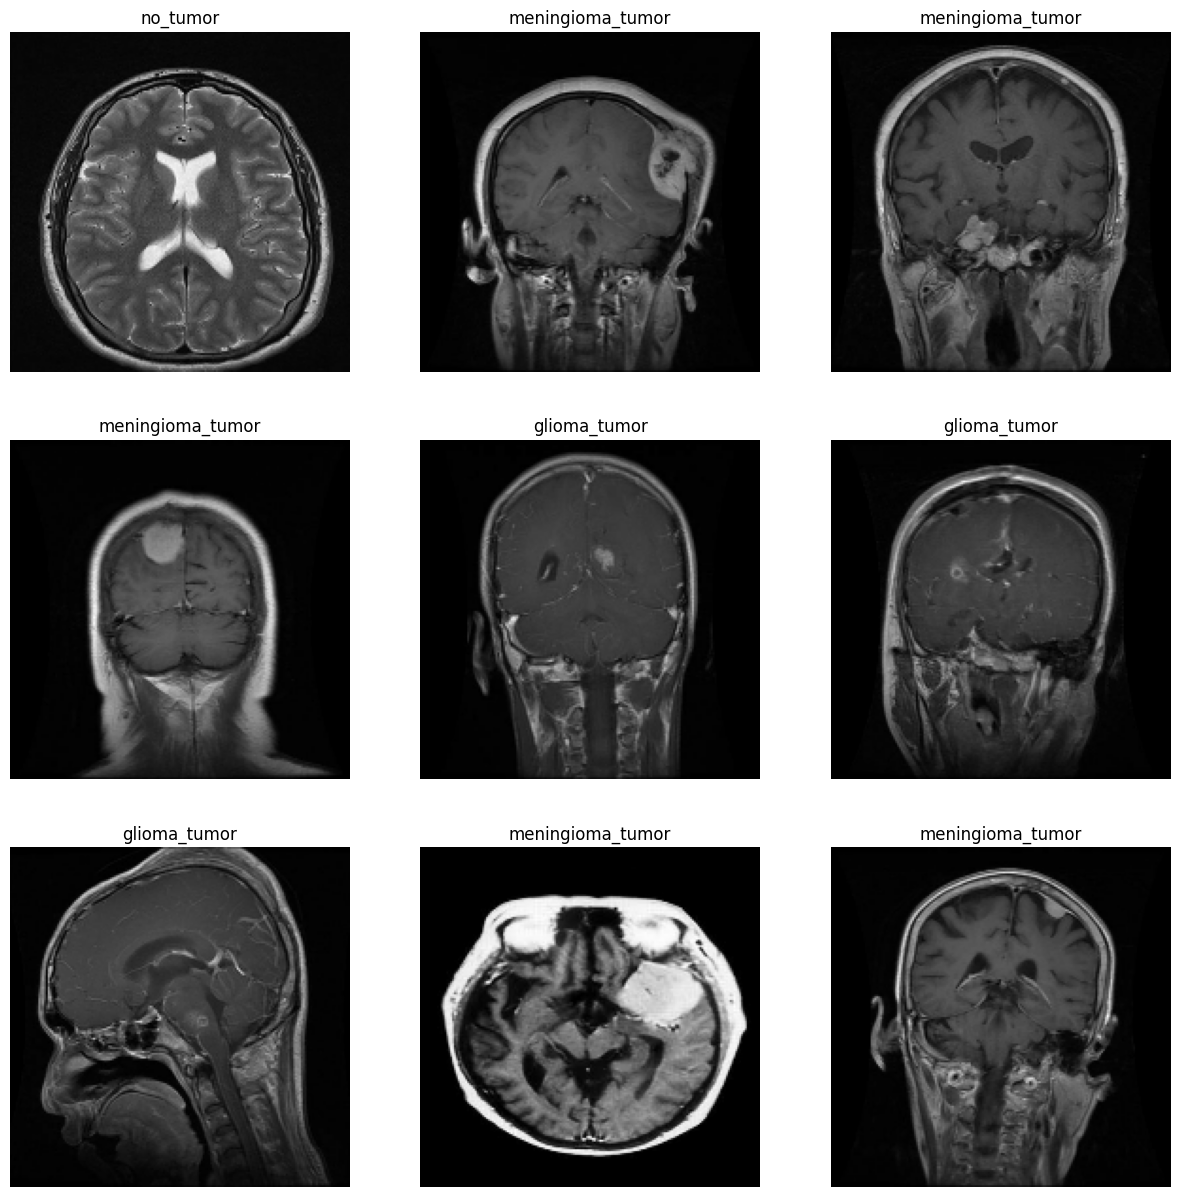

In [4]:
#Visualizing the dataset
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

plt.savefig("/content/drive/MyDrive/brain_tumor_classification_dataset/Brain Tumor GitHub/dataset images example/brain_tumor_images_examples.png")

In [5]:
for image_batch, labels_batch in train_ds:
  print(f"Image batch shape: {image_batch.shape}")
  print(f"Labels batch shape: {labels_batch.shape}")
  break

Image batch shape: (32, 180, 180, 3)
Labels batch shape: (32,)


In [6]:
#Since we don't want I/O to become blocked then we will yield the data from disk.
# For this we use buffered prefetching

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [7]:
#Augmented model (data augmentation implementation)
inputs1 = tf.keras.layers.Input(shape=(image_height, image_width, 3))
x = tf.keras.layers.Rescaling(1./255)(inputs1)
x = tf.keras.layers.RandomFlip("horizontal")(x)
x = tf.keras.layers.RandomRotation(0.1)(x)
x = tf.keras.layers.RandomZoom(0.1)(x)
x = tf.keras.layers.Conv2D(16, 3, activation="relu")(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Conv2D(32, 3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
outputs1 = tf.keras.layers.Dense(4, activation="softmax")(x)

augmented_model = tf.keras.models.Model(inputs=inputs1, outputs=outputs1)

augmented_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

In [8]:
augmented_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip (RandomFlip)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 89, 89, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 43, 43, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 59168)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       3,786,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,792,164 (14.47 MB)

 Trainable params: 3,792,164 (14.47 MB)

 Non-trainable params: 0 (0.00 B)

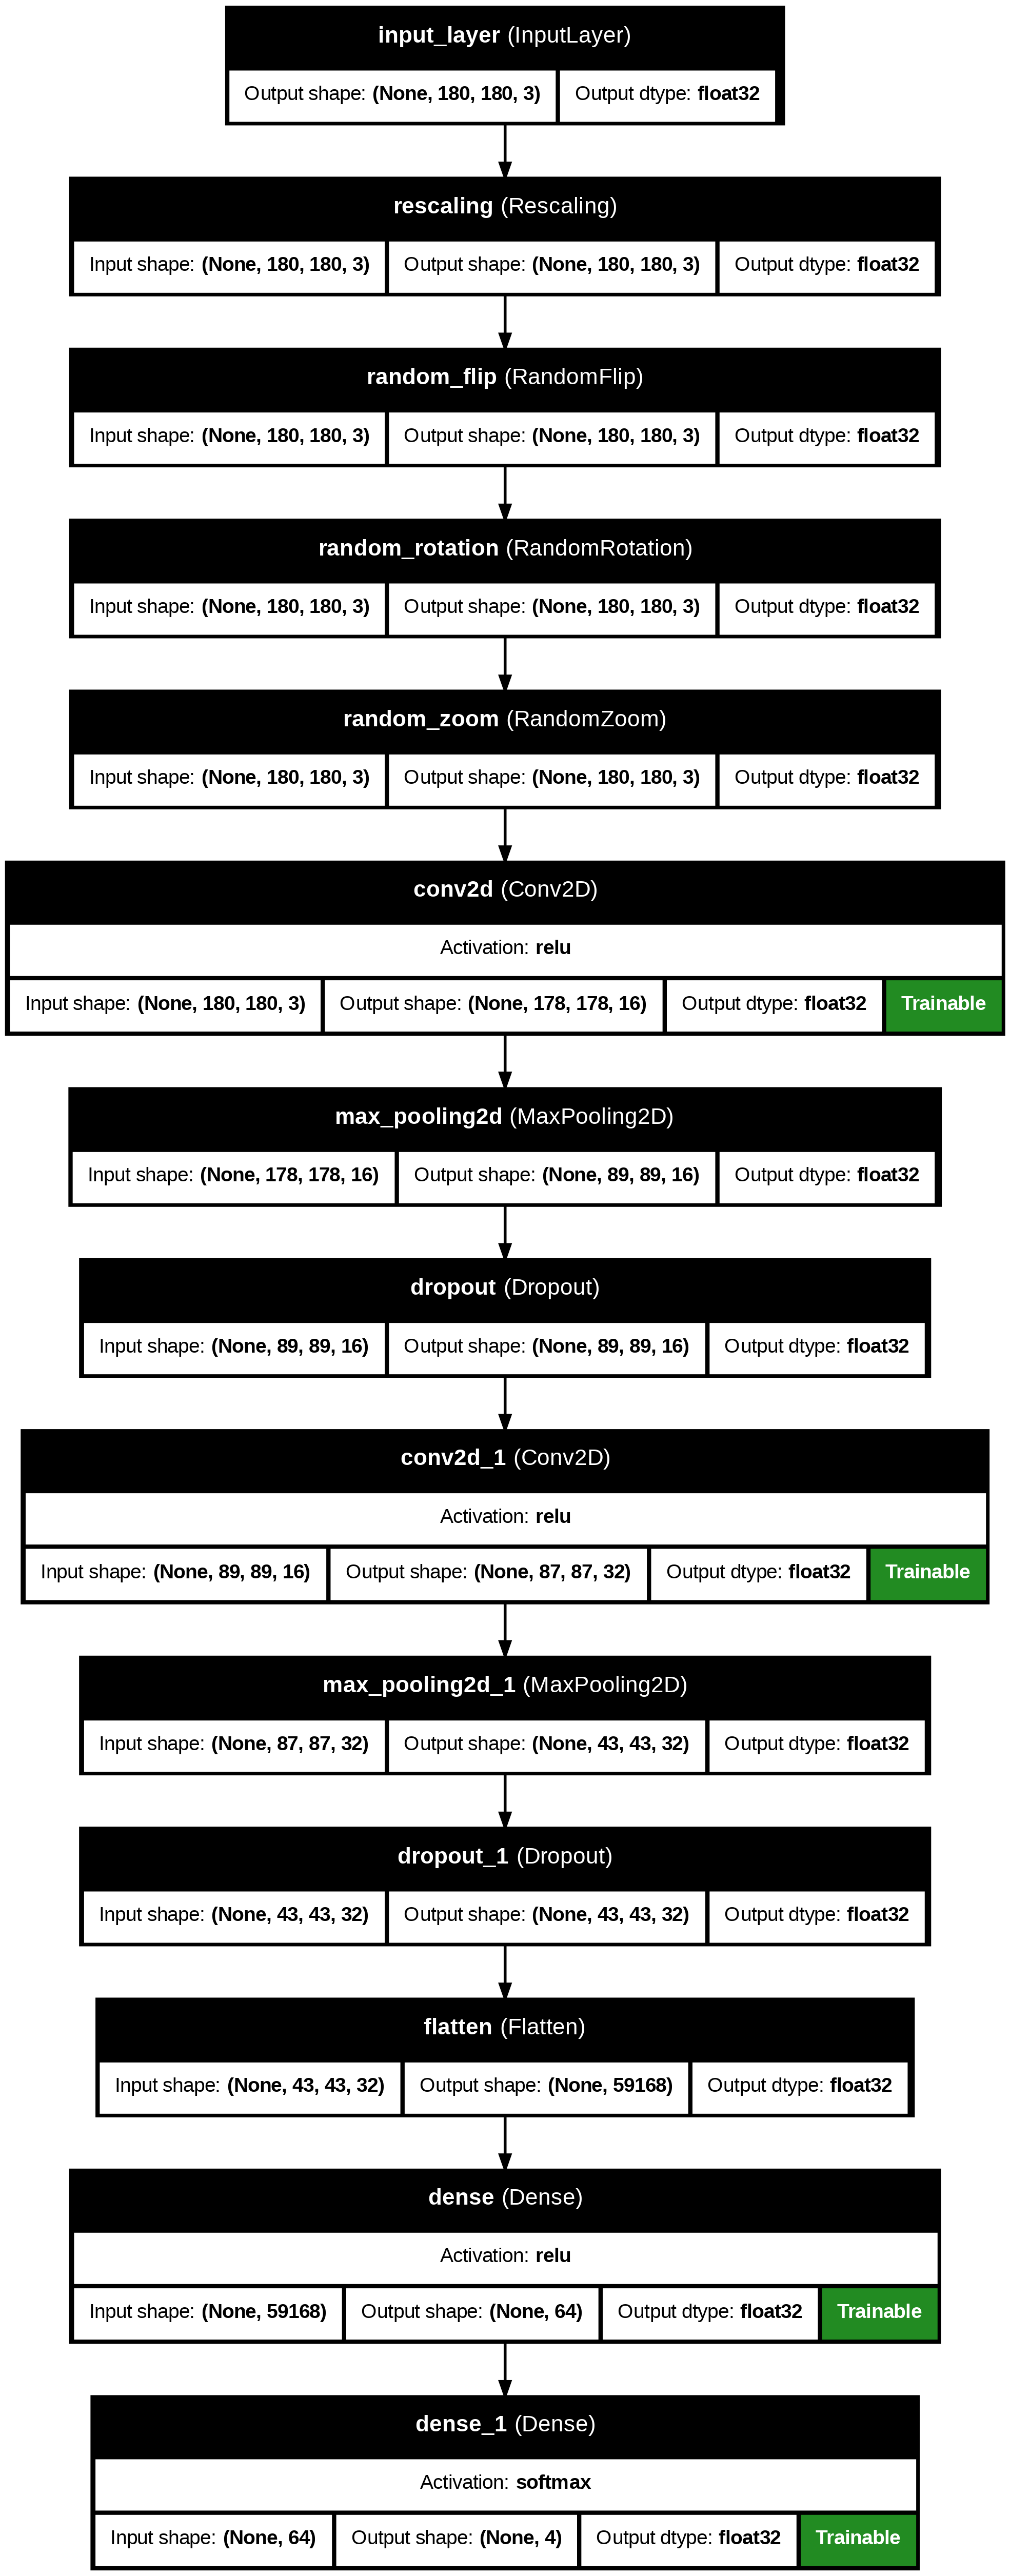

In [9]:
tf.keras.utils.plot_model(augmented_model, to_file = "/content/drive/MyDrive/brain_tumor_classification_dataset/Brain Tumor GitHub/Augmented Model/Model Architecture/augmented_model_architecture.png", show_shapes=True, show_dtype=True, show_layer_activations=True, show_layer_names=True, rankdir="TB", dpi=200, show_trainable=True)

In [10]:
early_stopping1 = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="auto", patience=5)
augmented_model_progress = augmented_model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[early_stopping1])

Epoch 1/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 697s 2s/step - accuracy: 0.3960 - loss: 1.5886 - val_accuracy: 0.4599 - val_loss: 1.2329
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.4627 - loss: 1.1783 - val_accuracy: 0.5523 - val_loss: 1.0358
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5938 - loss: 0.9719 - val_accuracy: 0.6028 - val_loss: 0.8726
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6352 - loss: 0.8659 - val_accuracy: 0.6481 - val_loss: 0.8009
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6942 - loss: 0.7479 - val_accuracy: 0.6864 - val_loss: 0.6778
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7024 - loss: 0.6954 - val_accuracy: 0.7509 - val_loss: 0.6171
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7086 - loss: 0.6831 - val_accuracy: 0.7213 - val_loss: 0.5887
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7427 - loss: 0.6175 - val_accuracy: 0.

In [12]:
augmented_model_history = pd.DataFrame(augmented_model_progress.history)
augmented_model_history.to_csv("/content/drive/MyDrive/brain_tumor_classification_dataset/Brain Tumor GitHub/Augmented Model/Model Training History/augmented_model_history.csv")

In [13]:
augmented_model.evaluate(val_ds)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8227 - loss: 0.4238


[0.4273958206176758, 0.8292682766914368]

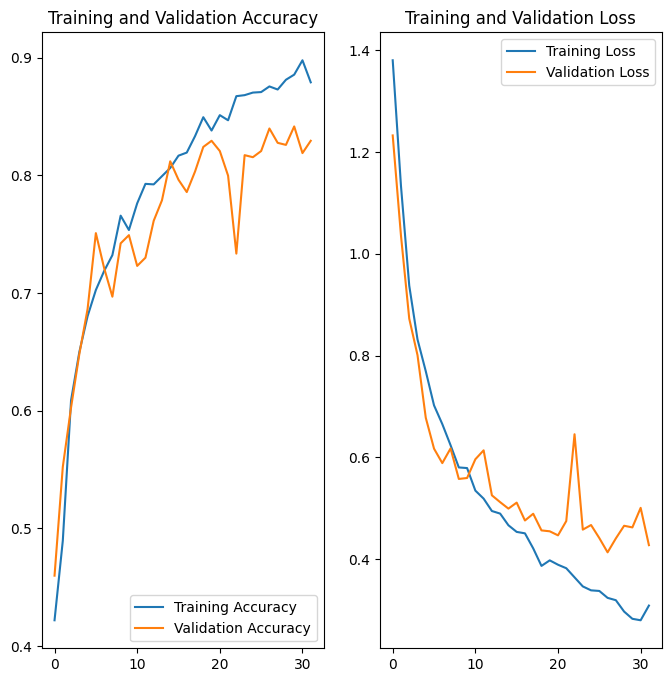

In [14]:
acc = augmented_model_progress.history['accuracy']
val_acc = augmented_model_progress.history['val_accuracy']

loss = augmented_model_progress.history['loss']
val_loss = augmented_model_progress.history['val_loss']

epochs_range = range(len(augmented_model_progress.history["loss"]))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.savefig("/content/drive/MyDrive/brain_tumor_classification_dataset/Brain Tumor GitHub/Augmented Model/Training and Validation Accuracy Loss/augmented_model_graph.png")
plt.show()

In [15]:
path = "/content/drive/MyDrive/brain_tumor_classification_dataset/brain_tumor_dataset/brain_tumor_classification/Testing/glioma_tumor/image(19).jpg"

img = tf.keras.utils.load_img(
    path, target_size=(image_height, image_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = augmented_model.predict(img_array)
score = tf.nn.softmax(predictions[0])



print(
    "First diagnostic scan indicates the presence of {} anomaly with a {:.2f}% probability."
    .format(class_names[tf.math.top_k(score, k=2).indices.numpy()[0]], 100 * tf.math.top_k(score, k=2).values.numpy()[0])
)

print(" ")

print(
    "The secondary outcome suggests {} anomaly with a {:.2f}% probability of occurrence."
    .format(class_names[tf.math.top_k(score, k=2).indices.numpy()[1]], 100 * tf.math.top_k(score, k=2).values.numpy()[1])
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
First diagnostic scan indicates the presence of no_tumor anomaly with a 47.53% probability.
 
The secondary outcome suggests meningioma_tumor anomaly with a 17.49% probability of occurrence.
